In [4]:
import pandas as pd
import numpy as np
import copy
import sys
import os
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
curr_dir = os.getcwd()
data_folder = os.path.join(curr_dir, "dados_camara_todos.csv")
dataset = pd.read_csv(data_folder)
#dataset = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\CT15Mn-150818_101018\\dados_camara.csv")#dados mais recentes
#tomtom = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\tomtom_data.csv")
#dataset = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\periodic_data.csv") #dados periodicos gerados automaticamente
#dataset = pd.read_csv("\\Users\\ASUS\\Documents\\IST\\5ºAno\\dados_old.csv") #dados mais antigos
dataset['unique_id'] = dataset.Zona.astype(str) + '_' + dataset.ID_Espira.astype(str)
dataset['unique_id'] = dataset['unique_id'].str.lower()
dataset_uid = dataset[(dataset["unique_id"] == "22_ct5")]

dataset_uid = dataset_uid.drop(columns=["Zona","Contadores","ID_Espira","unique_id"])
dt2 = copy.deepcopy(dataset_uid)
#dataset.sort_values(['Data'],ascending=True).groupby('Data').reset_index()

dataset_uid = dataset_uid.groupby('Data').apply(lambda x: x.reset_index())

msk = np.random.rand(len(dataset_uid)) < 0.7
train_df = dataset_uid[msk]
test_df = dataset_uid[~msk]





dt2.to_csv("limited_data.csv", sep= ',', index=False)
#train_set
train_df = train_df.drop(columns=["index"])

train_df.to_csv("train.csv", sep= ',', index=False)

#test_set
test_df = test_df.drop(columns=["index"])
test_df.to_csv("test.csv", sep= ',', index=False)

#full set
dataset_uid = dataset_uid.drop(columns=["index"])
dataset_uid.to_csv("dados_nn.csv", sep=',', index=False)



In [127]:
#espira confluente (opcional)
#cmp= espira complementar
cmp_data = dataset[(dataset["unique_id"] == "22_ct2")]
cmp_data = cmp_data.drop(columns=["Zona","Contadores","ID_Espira","unique_id"])
train_cmp_data = cmp_data[cmp_data["Data"].isin(train_df["Data"])]
train_cmp_data = train_cmp_data.groupby('Data').apply(lambda x: x.reset_index())
train_cmp_data = train_cmp_data.drop(columns=["index"])

train_cmp_data.to_csv("train_cmp.csv", sep= ',', index=False)


test_cmp_data = cmp_data[cmp_data["Data"].isin(test_df["Data"])]
test_cmp_data = test_cmp_data.groupby('Data').apply(lambda x: x.reset_index())
test_cmp_data = test_cmp_data.drop(columns=["index"])

test_cmp_data.to_csv("test_cmp.csv", sep= ',', index=False)
#print(cmp_data)

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [5]:
def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
hours = [dt.strftime('%H:%M') for dt in datetime_range(datetime(2018, 8, 15, 0, 0), datetime(2018, 8, 15, 23, 59), timedelta(minutes=15))]

In [6]:
#smoothing using std_dev and mean
from scipy import stats
import statistics


import numpy as np

train_cp = copy.deepcopy(train_df)
test_cp = copy.deepcopy(test_df)

def smooth_data(train_cp,filename):
    data = train_cp.iloc[:,0]
    print(len(data.values))
    train_cp = train_cp.drop(columns=["Data"])
    train_cp = train_cp.values

    #train_cp = train_cp.astype('float32')

    avg_list = []
    std_list = []
    for i in range(len(train_cp[0])):
        curr_avg = sum(train_cp[:,i])/len(train_cp[:,i])
        avg_list.append(curr_avg)
        std_list.append(statistics.stdev(train_cp[:,i]))
    #FIX sera que e preciso guardar os valores antigos e usá-los para fazer os updates? 
    #agora esta a fazer uma especie de moving average, utilizando os valores novos nos updates seguintes


    
    for row in range(len(train_cp)):
        number_of_changes= 0
        for column in range(len(train_cp[0])):
            if (train_cp[row][column] > (avg_list[column] + 2*std_list[column])):
                old_value = train_cp[row][column]
                if column == 0:
                    previous_t = train_cp[row,-1]
                    next_t = train_cp[row,column+1]
                    train_cp[row,column] = (previous_t + next_t)/2
                    number_of_changes+=1
                if column == 95:
                    previous_t = train_cp[row,column-1]
                    next_t = train_cp[row,0]
                    train_cp[row,column] = (previous_t + next_t)/2
                    number_of_changes+=1
                else:
                    previous_t = train_cp[row,column-1]
                    next_t = train_cp[row,column+1]
                    train_cp[row,column] = (previous_t + next_t)/2
                    number_of_changes+=1
                new_value = train_cp[row][column]
        print("Number of changes: " + str(number_of_changes))
                
    new_d = data.values.reshape(len(data.values),1)
    test = np.concatenate((new_d,train_cp),axis=1)
    pd.DataFrame(test).to_csv(str(filename) + ".csv", sep=',', index=False)
    return test, train_cp
smooth_train, df_train= smooth_data(train_cp, "train_2")
smooth_test, df_test = smooth_data(test_cp, "test_2")


train_cmp_cp = copy.deepcopy(train_cmp_data)
test_cmp_cp = copy.deepcopy(test_cmp_data)

smooth_train_cmp, df_train_cmp= smooth_data(train_cmp_cp, "train_cmp_2")
smooth_test_cmp, df_test_cmp= smooth_data(test_cmp_cp, "test_cmp_2")


121
Number of changes: 21
Number of changes: 12
Number of changes: 7
Number of changes: 8
Number of changes: 6
Number of changes: 12
Number of changes: 8
Number of changes: 6
Number of changes: 7
Number of changes: 3
Number of changes: 9
Number of changes: 0
Number of changes: 10
Number of changes: 5
Number of changes: 3
Number of changes: 2
Number of changes: 0
Number of changes: 2
Number of changes: 3
Number of changes: 1
Number of changes: 2
Number of changes: 4
Number of changes: 4
Number of changes: 2
Number of changes: 0
Number of changes: 3
Number of changes: 6
Number of changes: 3
Number of changes: 0
Number of changes: 0
Number of changes: 0
Number of changes: 2
Number of changes: 7
Number of changes: 0
Number of changes: 1
Number of changes: 2
Number of changes: 0
Number of changes: 0
Number of changes: 0
Number of changes: 0
Number of changes: 0
Number of changes: 3
Number of changes: 1
Number of changes: 0
Number of changes: 2
Number of changes: 4
Number of changes: 5
Numbe

NameError: name 'train_cmp_data' is not defined

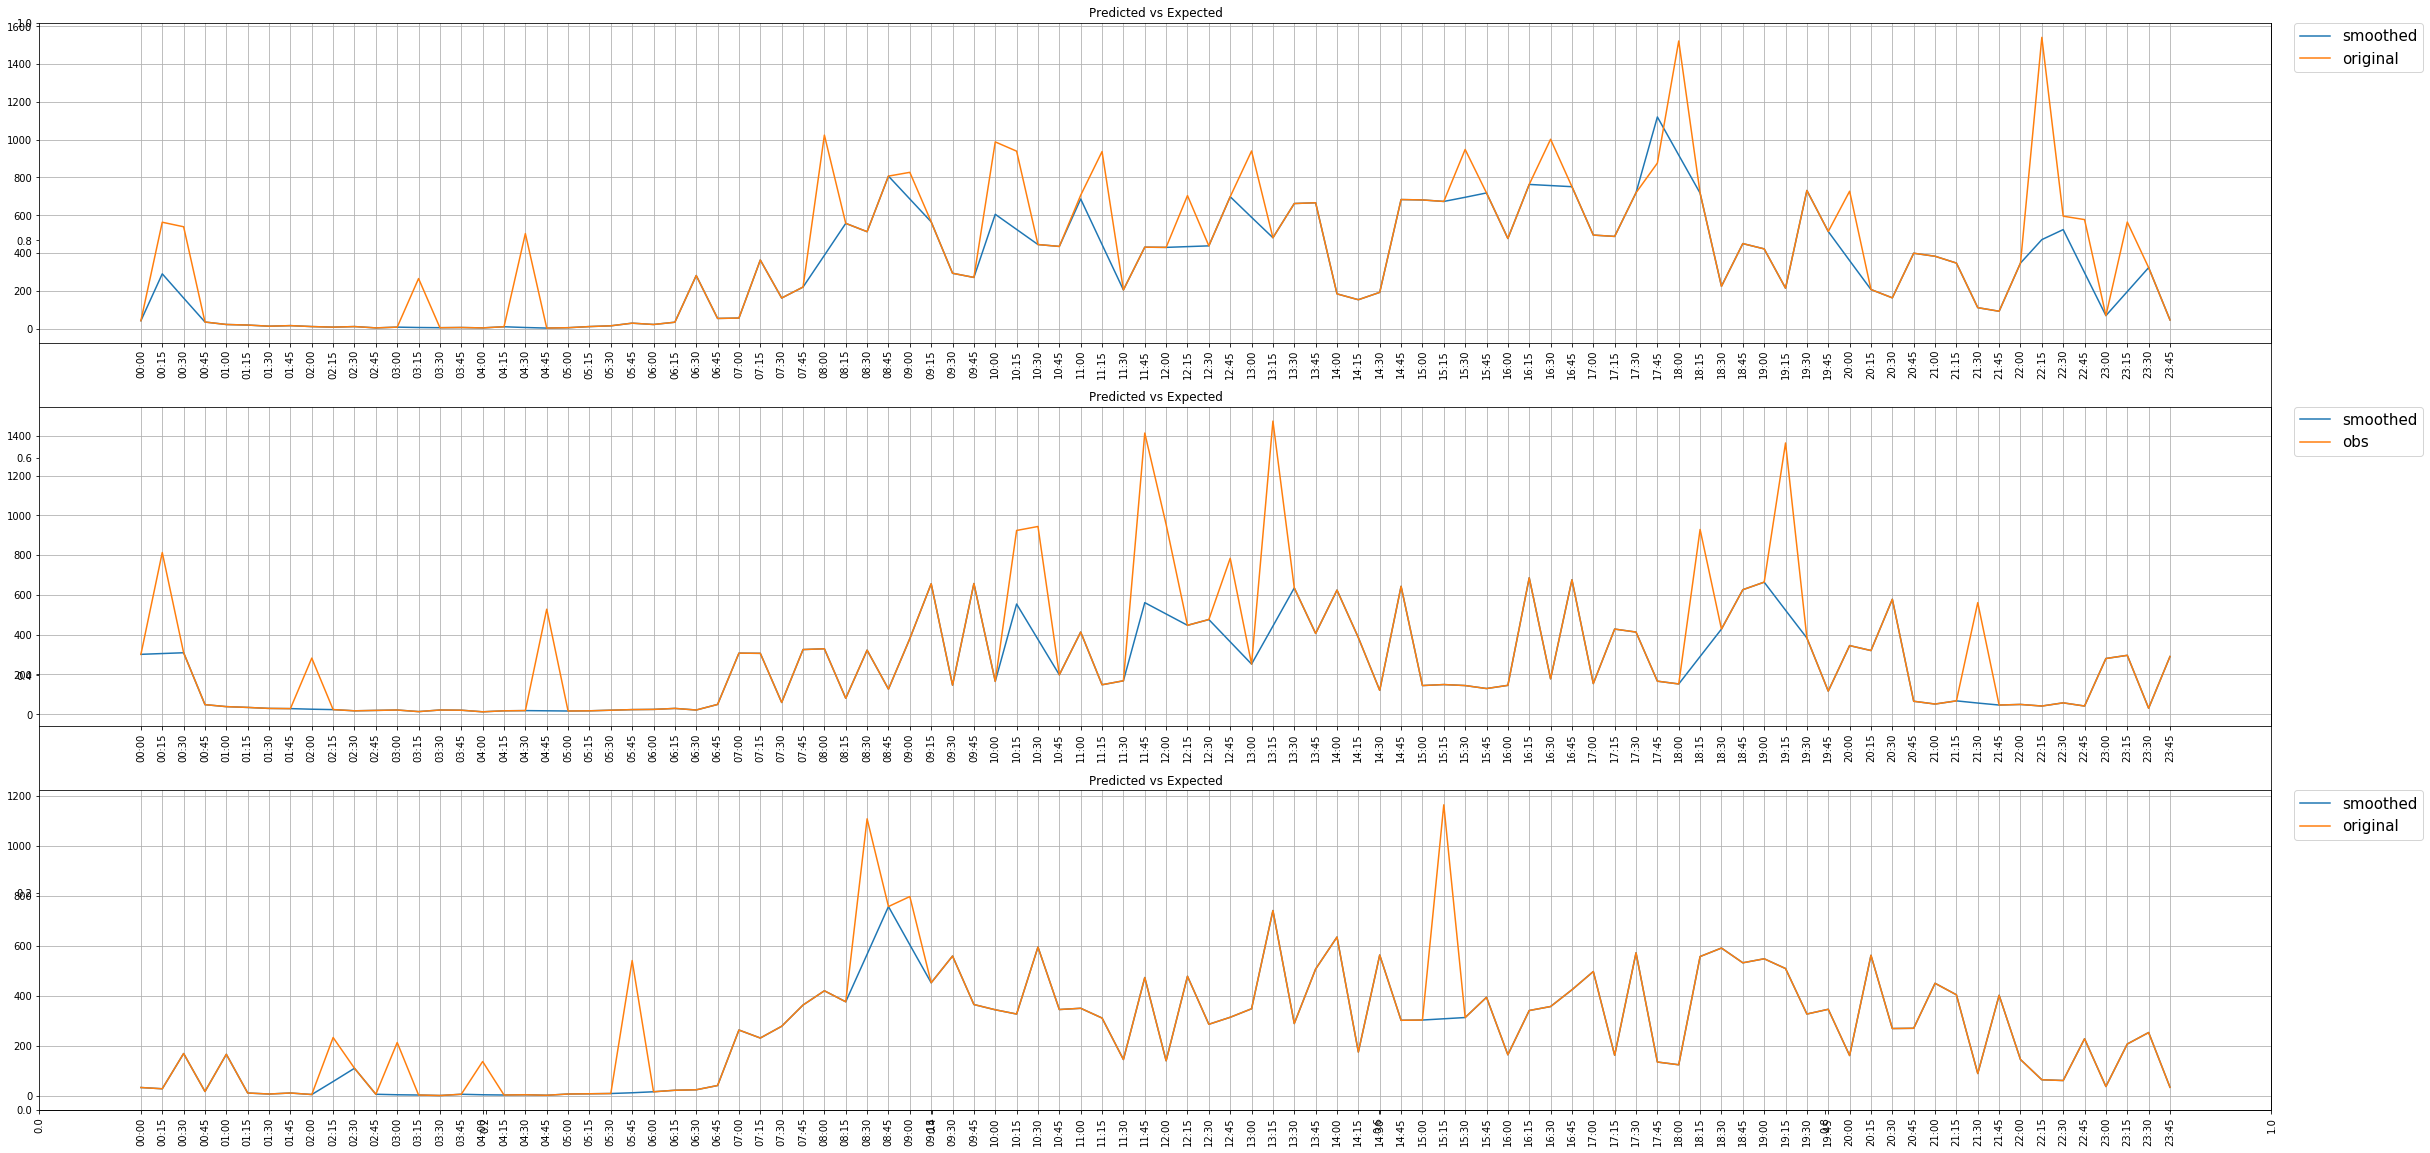

In [7]:
hours = [dt.strftime('%H:%M') for dt in 
       datetime_range(datetime(2018, 8, 15, 0, 0), datetime(2018, 8, 15, 23, 59), 
       timedelta(minutes=15))]


dataframe = pd.read_csv('train.csv')
dataset = dataframe.drop(columns=["Data"])
dataset = dataset.values
train = dataset.astype('float32')

dataframe = pd.read_csv('test.csv')
dataset = dataframe.drop(columns=["Data"])
dataset = dataset.values
test = dataset.astype('float32')

dataframe = pd.read_csv('train_cmp.csv')
dataset = dataframe.drop(columns=["Data"])
dataset = dataset.values
train_cmp = dataset.astype('float32')

def plot_changes(original, smooth):
    fig = plt.figure(3)

    plt.xticks(rotation=90)
    ax = fig.add_subplot(311)
    ax.plot(hours,smooth[0], label="smoothed")
    ax.plot(hours,original[0], label="original")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)

    ax = fig.add_subplot(312)
    ax.plot(hours,smooth[1], label="smoothed")
    ax.plot(hours,original[1], label="obs")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)

    ax = fig.add_subplot(313)
    ax.plot(hours,smooth[2], label="smoothed")
    ax.plot(hours,original[2], label="original")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)
    fig.set_size_inches(40, 20)
    fig.savefig(curr_dir + "\\smoothing\\" +"avg_2stdev_cmp.png", dpi=200)
#plot_changes(train_cmp, df_train_cmp)
plot_changes(train, df_train)



In [8]:
def transform_data(in_file, out_file, nrows=-1):
    in_file = open(str(in_file),"r")
    next(in_file)
    out_file = open(str(out_file),"w")
    out_file.write("t-3,t-2,t-1,Y\n") #header
    k = 0    
    lines = in_file.readlines()
    for line in lines:
        line = line.split(",")
        line = line[1:]
        line[-1] = line[-1].replace("\n","") #last data record has a \n
        its = [iter(line), iter(line[1:]), iter(line[2:]),iter(line[3:])] #Construct the pattern for longer windowss
        x = list(zip(*its))
        if (k == nrows):
            break
            
        k+=1 
#print(x)
    #j = 0
    #while(j<50): #this cycle was for creating a mock dataset with repeated data for testing purposes
        for i in x:
        #print(i[0],i[1],i[2],i[3])
            out_file.write(i[0] + "," + i[1] +"," + i[2] +","+ i[3])
            out_file.write("\n")
     #   j+=1
    
    in_file.close()
    out_file.close()
transform_data("dados_nn.csv", "new_f.csv")
transform_data("dados_nn.csv", "3day_nn.csv", 3)
transform_data("test_2.csv", "test_formatted.csv")
transform_data("test_2.csv", "3day_unsmoothed.csv",3)
transform_data("train_2.csv", "train_formatted.csv")
transform_data("train_cmp_2.csv", "train_cmp_formatted.csv")
transform_data("train_cmp.csv", "train_cmp_nosmooth.csv")

transform_data("test_cmp_2.csv", "test_cmp_formatted.csv")


In [116]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
###########FREEWAY DATASET############################

def create_dataset2(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)
# load the dataset
dataframe = pd.read_csv('freeway_data1.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))
# demonstrate data normalization with sklearn 
def standardize_data(data):
    # create scaler
    scaler = StandardScaler()
    # fit scaler on data
    scaler.fit(data)
    # apply transform
    normalized = scaler.transform(data)
    # inverse transform
    inverse = scaler.inverse_transform(normalized)
    #print(inverse)
    #print(normalized)
    return scaler, normalized
scaler, normalized = standardize_data(train)
f_trainX, f_trainY = create_dataset2(train,3)
f_testX, f_testY =create_dataset2(test,3)



9676 2420


In [9]:
import numpy
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
import sys

# fix random seed for reproducibility
#numpy.random.seed(7)

#dataframe = pd.read_csv('new_f.csv') #raw data
#dataset = dataframe.values
#dataset = dataset.astype('float32')
#dataframe = pd.read_csv('test.csv') #data generated by reusing the same day 50 times


dataframe = pd.read_csv('train_formatted.csv')
dataset = dataframe.values
train_set = dataset.astype('float32')

dataframe = pd.read_csv('test_formatted.csv')
dataset = dataframe.values
test_set = dataset.astype('float32')

dataframe = pd.read_csv('train_cmp_formatted.csv')
dataset = dataframe.values
train_cmp_set = dataset.astype('float32')

dataframe = pd.read_csv('test_cmp_formatted.csv')
dataset = dataframe.values
test_cmp_set = dataset.astype('float32')

dataframe = pd.read_csv('train_cmp_nosmooth.csv')
dataset = dataframe.values
no_smooth = dataset.astype('float32')


def create_dataset(data):
    X,Y = [],[]
    for i in data:
        X.append(i[:3])
        Y.append(i[3])
    return numpy.array(X), numpy.array(Y)
print(len(train_set))
print(len(test_set))
print(len(train_cmp_set))
trainX, trainY = create_dataset(train_set)

testX, testY = create_dataset(test_set)
trainX_cmp,trainY_cmp = create_dataset(train_cmp_set)

#print(trainX)
#print(trainX_cmp)

#trainX_both = np.concatenate((trainX, trainX_cmp), axis=1)
#print(trainX_both)




11253
3999
11160


In [16]:
import numpy
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers
import sys


model = Sequential()
layer1 = Dense(64,input_dim=3, activation='relu',kernel_regularizer=regularizers.l2(0.01))
layer2 = Dense(64, activation='relu',kernel_regularizer=regularizers.l2(0.01))
layer3 = Dense(32, activation='relu',kernel_regularizer=regularizers.l2(0.01))
#layer3 = Dense(400, activation='relu')
model.add(layer1)
model.add(layer2)
#model.add(layer2)
#model.add(Dense(8, activation='relu'))
model.add(Dense(1,activation='linear'))
sgd = optimizers.SGD(lr=0.001)

adam=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
rmsprop = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='mean_squared_error', optimizer=adam,metrics=['mape', 'mae', 'mse'])
history= model.fit(trainX, trainY, epochs=600, verbose=1, batch_size=64, validation_split=0.2)

Train on 9002 samples, validate on 2251 samples
Epoch 1/600
9002/9002 [==============================] - 1s 140us/step - loss: 25473.5977 - mean_absolute_percentage_error: 65385706.8203 - mean_absolute_error: 113.7631 - mean_squared_error: 25473.0445 - val_loss: 23766.8836 - val_mean_absolute_percentage_error: 299231081.0994 - val_mean_absolute_error: 112.5259 - val_mean_squared_error: 23766.4109
Epoch 2/600
9002/9002 [==============================] - 1s 62us/step - loss: 22435.1074 - mean_absolute_percentage_error: 72294138.6090 - mean_absolute_error: 108.6035 - mean_squared_error: 22434.6494 - val_loss: 23823.4129 - val_mean_absolute_percentage_error: 314521640.4630 - val_mean_absolute_error: 112.8830 - val_mean_squared_error: 23822.9582
Epoch 3/600
9002/9002 [==============================] - 0s 51us/step - loss: 22396.6954 - mean_absolute_percentage_error: 76717541.9961 - mean_absolute_error: 108.4686 - mean_squared_error: 22396.2371 - val_loss: 23790.6415 - val_mean_absolute_perc

9002/9002 [==============================] - 0s 38us/step - loss: 20937.6750 - mean_absolute_percentage_error: 195153079.2356 - mean_absolute_error: 108.4149 - mean_squared_error: 20936.4759 - val_loss: 22975.7266 - val_mean_absolute_percentage_error: 265190496.9283 - val_mean_absolute_error: 113.4030 - val_mean_squared_error: 22974.5118
Epoch 48/600
9002/9002 [==============================] - 0s 38us/step - loss: 20857.9845 - mean_absolute_percentage_error: 194506807.9958 - mean_absolute_error: 108.4438 - mean_squared_error: 20856.7508 - val_loss: 22009.7347 - val_mean_absolute_percentage_error: 255456451.3308 - val_mean_absolute_error: 112.8226 - val_mean_squared_error: 22008.4847
Epoch 49/600
9002/9002 [==============================] - 0s 39us/step - loss: 20921.4961 - mean_absolute_percentage_error: 188720815.1316 - mean_absolute_error: 108.5598 - mean_squared_error: 20920.2268 - val_loss: 22259.2141 - val_mean_absolute_percentage_error: 246125966.8796 - val_mean_absolute_error: 

9002/9002 [==============================] - 0s 38us/step - loss: 20110.1919 - mean_absolute_percentage_error: 91913706.7264 - mean_absolute_error: 106.1934 - mean_squared_error: 20108.0438 - val_loss: 21694.4577 - val_mean_absolute_percentage_error: 260861359.9755 - val_mean_absolute_error: 111.5765 - val_mean_squared_error: 21692.3056
Epoch 94/600
9002/9002 [==============================] - 0s 37us/step - loss: 20116.1068 - mean_absolute_percentage_error: 79910402.6448 - mean_absolute_error: 106.0487 - mean_squared_error: 20113.9496 - val_loss: 21865.3261 - val_mean_absolute_percentage_error: 236728255.2327 - val_mean_absolute_error: 110.5875 - val_mean_squared_error: 21863.1598
Epoch 95/600
9002/9002 [==============================] - 0s 41us/step - loss: 20118.8295 - mean_absolute_percentage_error: 88502839.3062 - mean_absolute_error: 106.2064 - mean_squared_error: 20116.6576 - val_loss: 21558.2827 - val_mean_absolute_percentage_error: 274007571.2204 - val_mean_absolute_error: 112

9002/9002 [==============================] - 0s 40us/step - loss: 19982.6456 - mean_absolute_percentage_error: 130281780.2155 - mean_absolute_error: 106.0722 - mean_squared_error: 19979.9282 - val_loss: 21893.6451 - val_mean_absolute_percentage_error: 293080083.5319 - val_mean_absolute_error: 110.5978 - val_mean_squared_error: 21890.9200
Epoch 140/600
9002/9002 [==============================] - 0s 37us/step - loss: 20051.6312 - mean_absolute_percentage_error: 125066336.1547 - mean_absolute_error: 105.8864 - mean_squared_error: 20048.9008 - val_loss: 21503.5432 - val_mean_absolute_percentage_error: 306420379.2987 - val_mean_absolute_error: 110.9959 - val_mean_squared_error: 21500.8069
Epoch 141/600
9002/9002 [==============================] - 0s 38us/step - loss: 19955.7529 - mean_absolute_percentage_error: 126805196.4078 - mean_absolute_error: 105.8163 - mean_squared_error: 19953.0068 - val_loss: 21563.8710 - val_mean_absolute_percentage_error: 279428644.6175 - val_mean_absolute_error

9002/9002 [==============================] - 0s 39us/step - loss: 19910.6851 - mean_absolute_percentage_error: 153962676.8341 - mean_absolute_error: 105.3865 - mean_squared_error: 19907.3353 - val_loss: 21654.1925 - val_mean_absolute_percentage_error: 359699163.1230 - val_mean_absolute_error: 111.0966 - val_mean_squared_error: 21650.8353
Epoch 186/600
9002/9002 [==============================] - 0s 40us/step - loss: 19921.3262 - mean_absolute_percentage_error: 156558832.4193 - mean_absolute_error: 105.6775 - mean_squared_error: 19917.9657 - val_loss: 21577.3946 - val_mean_absolute_percentage_error: 387869754.1104 - val_mean_absolute_error: 112.1541 - val_mean_squared_error: 21574.0272
Epoch 187/600
9002/9002 [==============================] - 0s 38us/step - loss: 19904.0100 - mean_absolute_percentage_error: 150101934.9704 - mean_absolute_error: 105.3889 - mean_squared_error: 19900.6321 - val_loss: 21644.3945 - val_mean_absolute_percentage_error: 348516580.3687 - val_mean_absolute_error

9002/9002 [==============================] - 0s 40us/step - loss: 19771.3947 - mean_absolute_percentage_error: 138429585.6060 - mean_absolute_error: 105.0737 - mean_squared_error: 19767.4528 - val_loss: 21680.3524 - val_mean_absolute_percentage_error: 346363431.6872 - val_mean_absolute_error: 110.1525 - val_mean_squared_error: 21676.4052
Epoch 232/600
9002/9002 [==============================] - 0s 47us/step - loss: 19869.2655 - mean_absolute_percentage_error: 162662786.0737 - mean_absolute_error: 105.2445 - mean_squared_error: 19865.3102 - val_loss: 21447.2957 - val_mean_absolute_percentage_error: 386120676.9429 - val_mean_absolute_error: 110.8332 - val_mean_squared_error: 21443.3330
Epoch 233/600
9002/9002 [==============================] - 0s 43us/step - loss: 19739.5168 - mean_absolute_percentage_error: 156667528.0159 - mean_absolute_error: 105.1084 - mean_squared_error: 19735.5468 - val_loss: 21577.0218 - val_mean_absolute_percentage_error: 353294323.0462 - val_mean_absolute_error

9002/9002 [==============================] - 0s 44us/step - loss: 19690.4284 - mean_absolute_percentage_error: 157952721.2852 - mean_absolute_error: 104.8078 - mean_squared_error: 19685.9066 - val_loss: 21539.8780 - val_mean_absolute_percentage_error: 387629186.4128 - val_mean_absolute_error: 111.0070 - val_mean_squared_error: 21535.3486
Epoch 278/600
9002/9002 [==============================] - 0s 46us/step - loss: 19704.4218 - mean_absolute_percentage_error: 147966818.9515 - mean_absolute_error: 104.8734 - mean_squared_error: 19699.8870 - val_loss: 21598.1360 - val_mean_absolute_percentage_error: 407615545.0242 - val_mean_absolute_error: 111.9150 - val_mean_squared_error: 21593.5966
Epoch 279/600
9002/9002 [==============================] - 0s 41us/step - loss: 19692.4479 - mean_absolute_percentage_error: 149566664.1148 - mean_absolute_error: 105.0386 - mean_squared_error: 19687.8999 - val_loss: 21520.8054 - val_mean_absolute_percentage_error: 396277195.5659 - val_mean_absolute_error

9002/9002 [==============================] - 0s 39us/step - loss: 19701.8174 - mean_absolute_percentage_error: 135792169.8516 - mean_absolute_error: 104.7913 - mean_squared_error: 19696.7225 - val_loss: 21563.7970 - val_mean_absolute_percentage_error: 389113517.3085 - val_mean_absolute_error: 109.7369 - val_mean_squared_error: 21558.6952
Epoch 324/600
9002/9002 [==============================] - 0s 48us/step - loss: 19596.3533 - mean_absolute_percentage_error: 148722413.0345 - mean_absolute_error: 104.7697 - mean_squared_error: 19591.2449 - val_loss: 21469.9609 - val_mean_absolute_percentage_error: 397661557.5039 - val_mean_absolute_error: 109.8654 - val_mean_squared_error: 21464.8454
Epoch 325/600
9002/9002 [==============================] - 0s 41us/step - loss: 19606.0282 - mean_absolute_percentage_error: 139714008.5390 - mean_absolute_error: 104.6139 - mean_squared_error: 19600.9072 - val_loss: 21644.4534 - val_mean_absolute_percentage_error: 406166857.4083 - val_mean_absolute_error

9002/9002 [==============================] - 0s 40us/step - loss: 19626.4178 - mean_absolute_percentage_error: 136242254.7566 - mean_absolute_error: 104.6762 - mean_squared_error: 19620.7383 - val_loss: 21621.8173 - val_mean_absolute_percentage_error: 416940941.1664 - val_mean_absolute_error: 111.0805 - val_mean_squared_error: 21616.1319
Epoch 370/600
9002/9002 [==============================] - 0s 42us/step - loss: 19588.5153 - mean_absolute_percentage_error: 136916431.3193 - mean_absolute_error: 104.5984 - mean_squared_error: 19582.8207 - val_loss: 22030.1507 - val_mean_absolute_percentage_error: 360168677.2361 - val_mean_absolute_error: 110.0346 - val_mean_squared_error: 22024.4586
Epoch 371/600
9002/9002 [==============================] - 0s 48us/step - loss: 19654.2183 - mean_absolute_percentage_error: 132100257.0850 - mean_absolute_error: 104.4293 - mean_squared_error: 19648.5209 - val_loss: 21583.4284 - val_mean_absolute_percentage_error: 384870520.3347 - val_mean_absolute_error

9002/9002 [==============================] - 0s 38us/step - loss: 19622.7667 - mean_absolute_percentage_error: 141768056.9300 - mean_absolute_error: 104.7953 - mean_squared_error: 19616.5038 - val_loss: 21904.5231 - val_mean_absolute_percentage_error: 385112857.1971 - val_mean_absolute_error: 110.4425 - val_mean_squared_error: 21898.2515
Epoch 416/600
9002/9002 [==============================] - 0s 44us/step - loss: 19575.9979 - mean_absolute_percentage_error: 140733568.3822 - mean_absolute_error: 104.4215 - mean_squared_error: 19569.7177 - val_loss: 21554.9726 - val_mean_absolute_percentage_error: 373993834.1719 - val_mean_absolute_error: 109.8318 - val_mean_squared_error: 21548.6895
Epoch 417/600
9002/9002 [==============================] - 0s 43us/step - loss: 19464.7368 - mean_absolute_percentage_error: 136312023.3478 - mean_absolute_error: 104.2580 - mean_squared_error: 19458.4520 - val_loss: 22015.8811 - val_mean_absolute_percentage_error: 365099667.1658 - val_mean_absolute_error

9002/9002 [==============================] - 1s 61us/step - loss: 19498.5570 - mean_absolute_percentage_error: 142449648.3296 - mean_absolute_error: 104.2530 - mean_squared_error: 19491.6865 - val_loss: 21493.7478 - val_mean_absolute_percentage_error: 374059936.8303 - val_mean_absolute_error: 110.4136 - val_mean_squared_error: 21486.8750
Epoch 462/600
9002/9002 [==============================] - 1s 64us/step - loss: 19496.7824 - mean_absolute_percentage_error: 134453395.8194 - mean_absolute_error: 104.0289 - mean_squared_error: 19489.8988 - val_loss: 21500.6257 - val_mean_absolute_percentage_error: 407466553.7086 - val_mean_absolute_error: 109.7959 - val_mean_squared_error: 21493.7388
Epoch 463/600
9002/9002 [==============================] - 0s 52us/step - loss: 19417.4070 - mean_absolute_percentage_error: 139619257.5078 - mean_absolute_error: 103.9879 - mean_squared_error: 19410.5149 - val_loss: 21451.5164 - val_mean_absolute_percentage_error: 374779527.9997 - val_mean_absolute_error

9002/9002 [==============================] - 0s 48us/step - loss: 19392.9561 - mean_absolute_percentage_error: 144335616.7680 - mean_absolute_error: 103.9223 - mean_squared_error: 19385.4676 - val_loss: 21656.9072 - val_mean_absolute_percentage_error: 403468826.3210 - val_mean_absolute_error: 110.3988 - val_mean_squared_error: 21649.4111
Epoch 508/600
9002/9002 [==============================] - 0s 45us/step - loss: 19404.6017 - mean_absolute_percentage_error: 124848666.3261 - mean_absolute_error: 103.8263 - mean_squared_error: 19397.0953 - val_loss: 21539.3386 - val_mean_absolute_percentage_error: 398324369.4691 - val_mean_absolute_error: 110.0240 - val_mean_squared_error: 21531.8232
Epoch 509/600
9002/9002 [==============================] - 0s 49us/step - loss: 19569.9701 - mean_absolute_percentage_error: 134115229.7802 - mean_absolute_error: 104.1813 - mean_squared_error: 19562.4503 - val_loss: 21400.4855 - val_mean_absolute_percentage_error: 374152074.1000 - val_mean_absolute_error

9002/9002 [==============================] - 0s 40us/step - loss: 19399.5620 - mean_absolute_percentage_error: 133592495.8300 - mean_absolute_error: 103.8941 - mean_squared_error: 19391.4102 - val_loss: 22109.2945 - val_mean_absolute_percentage_error: 396834187.6011 - val_mean_absolute_error: 111.2642 - val_mean_squared_error: 22101.1400
Epoch 554/600
9002/9002 [==============================] - 0s 43us/step - loss: 19432.9056 - mean_absolute_percentage_error: 127002788.8244 - mean_absolute_error: 103.6594 - mean_squared_error: 19424.7428 - val_loss: 22079.0754 - val_mean_absolute_percentage_error: 449133933.0336 - val_mean_absolute_error: 113.7006 - val_mean_squared_error: 22070.8980
Epoch 555/600
9002/9002 [==============================] - 1s 62us/step - loss: 19351.0955 - mean_absolute_percentage_error: 128487949.6689 - mean_absolute_error: 104.0125 - mean_squared_error: 19342.9196 - val_loss: 21480.6917 - val_mean_absolute_percentage_error: 399026889.7231 - val_mean_absolute_error

9002/9002 [==============================] - 0s 41us/step - loss: 19327.6738 - mean_absolute_percentage_error: 115404586.3226 - mean_absolute_error: 103.7338 - mean_squared_error: 19318.8967 - val_loss: 21722.9081 - val_mean_absolute_percentage_error: 444635236.3710 - val_mean_absolute_error: 112.5020 - val_mean_squared_error: 21714.1190
Epoch 600/600
9002/9002 [==============================] - 0s 53us/step - loss: 19276.9315 - mean_absolute_percentage_error: 114422516.9860 - mean_absolute_error: 103.3689 - mean_squared_error: 19268.1334 - val_loss: 21712.5229 - val_mean_absolute_percentage_error: 455152769.6293 - val_mean_absolute_error: 112.8447 - val_mean_squared_error: 21703.7180


In [1]:
# summarize history for loss
fig = plt.figure(1)
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()
plt.close(fig)
fig.savefig("adam_w_l2_600.png",dpi=100)

NameError: name 'plt' is not defined

In [20]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import os
curr_dir = os.getcwd()


obs_df = pd.read_csv('3day_unsmoothed.csv')
obs = obs_df.values
obs = obs.astype('float32')

obsX, obsY = create_dataset(obs)
#print(obsX)
pred = model.predict(obsX)
#print(pred)
#print(obsY)

def datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta

dts = [dt.strftime('%H:%M') for dt in 
       datetime_range(datetime(2018, 8, 15, 0, 45), datetime(2018, 8, 15, 23, 59), 
       timedelta(minutes=15))]
print(len(pred[93:186]))
print(len(pred[186:279]))

#sys.exit()
#Esta feito para um gráfico ao longo de três dias 
def plot_results(dts, pred, obsY, plot_name):
    fig = plt.figure(2)
    plt.xticks(rotation=90)
    ax = fig.add_subplot(311)
    ax.plot(dts,pred[0:93], label="pred")
    ax.plot(dts,obsY[0:93], label="obs")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Predicted vs Expected")
    ax.tick_params(axis='x', rotation=90)

    ax2 = fig.add_subplot(312)
    ax2.plot(dts, pred[93:186], label="pred")
    ax2.plot(dts,obsY[93:186], label="obs")
    ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax2.grid(True)
    ax2.set_title("Predicted vs Expected")
    ax2.tick_params(axis='x', rotation=90)

    ax3 = fig.add_subplot(313)
    ax3.plot(dts, pred[186:279], label="pred")
    ax3.plot(dts,obsY[186:279], label="obs")
    ax3.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax3.grid(True)
    ax3.set_title("Predicted vs Expected")
    ax3.tick_params(axis='x', rotation=90)
    fig.set_size_inches(40, 20)
    fig.savefig(curr_dir + "\\results_nn\\" +str(plot_name)+".png", dpi=100)
plot_results(dts, pred, obsY, "linear_reg")

#plot_changes(test, df_test)

NameError: name 'create_dataset' is not defined

96


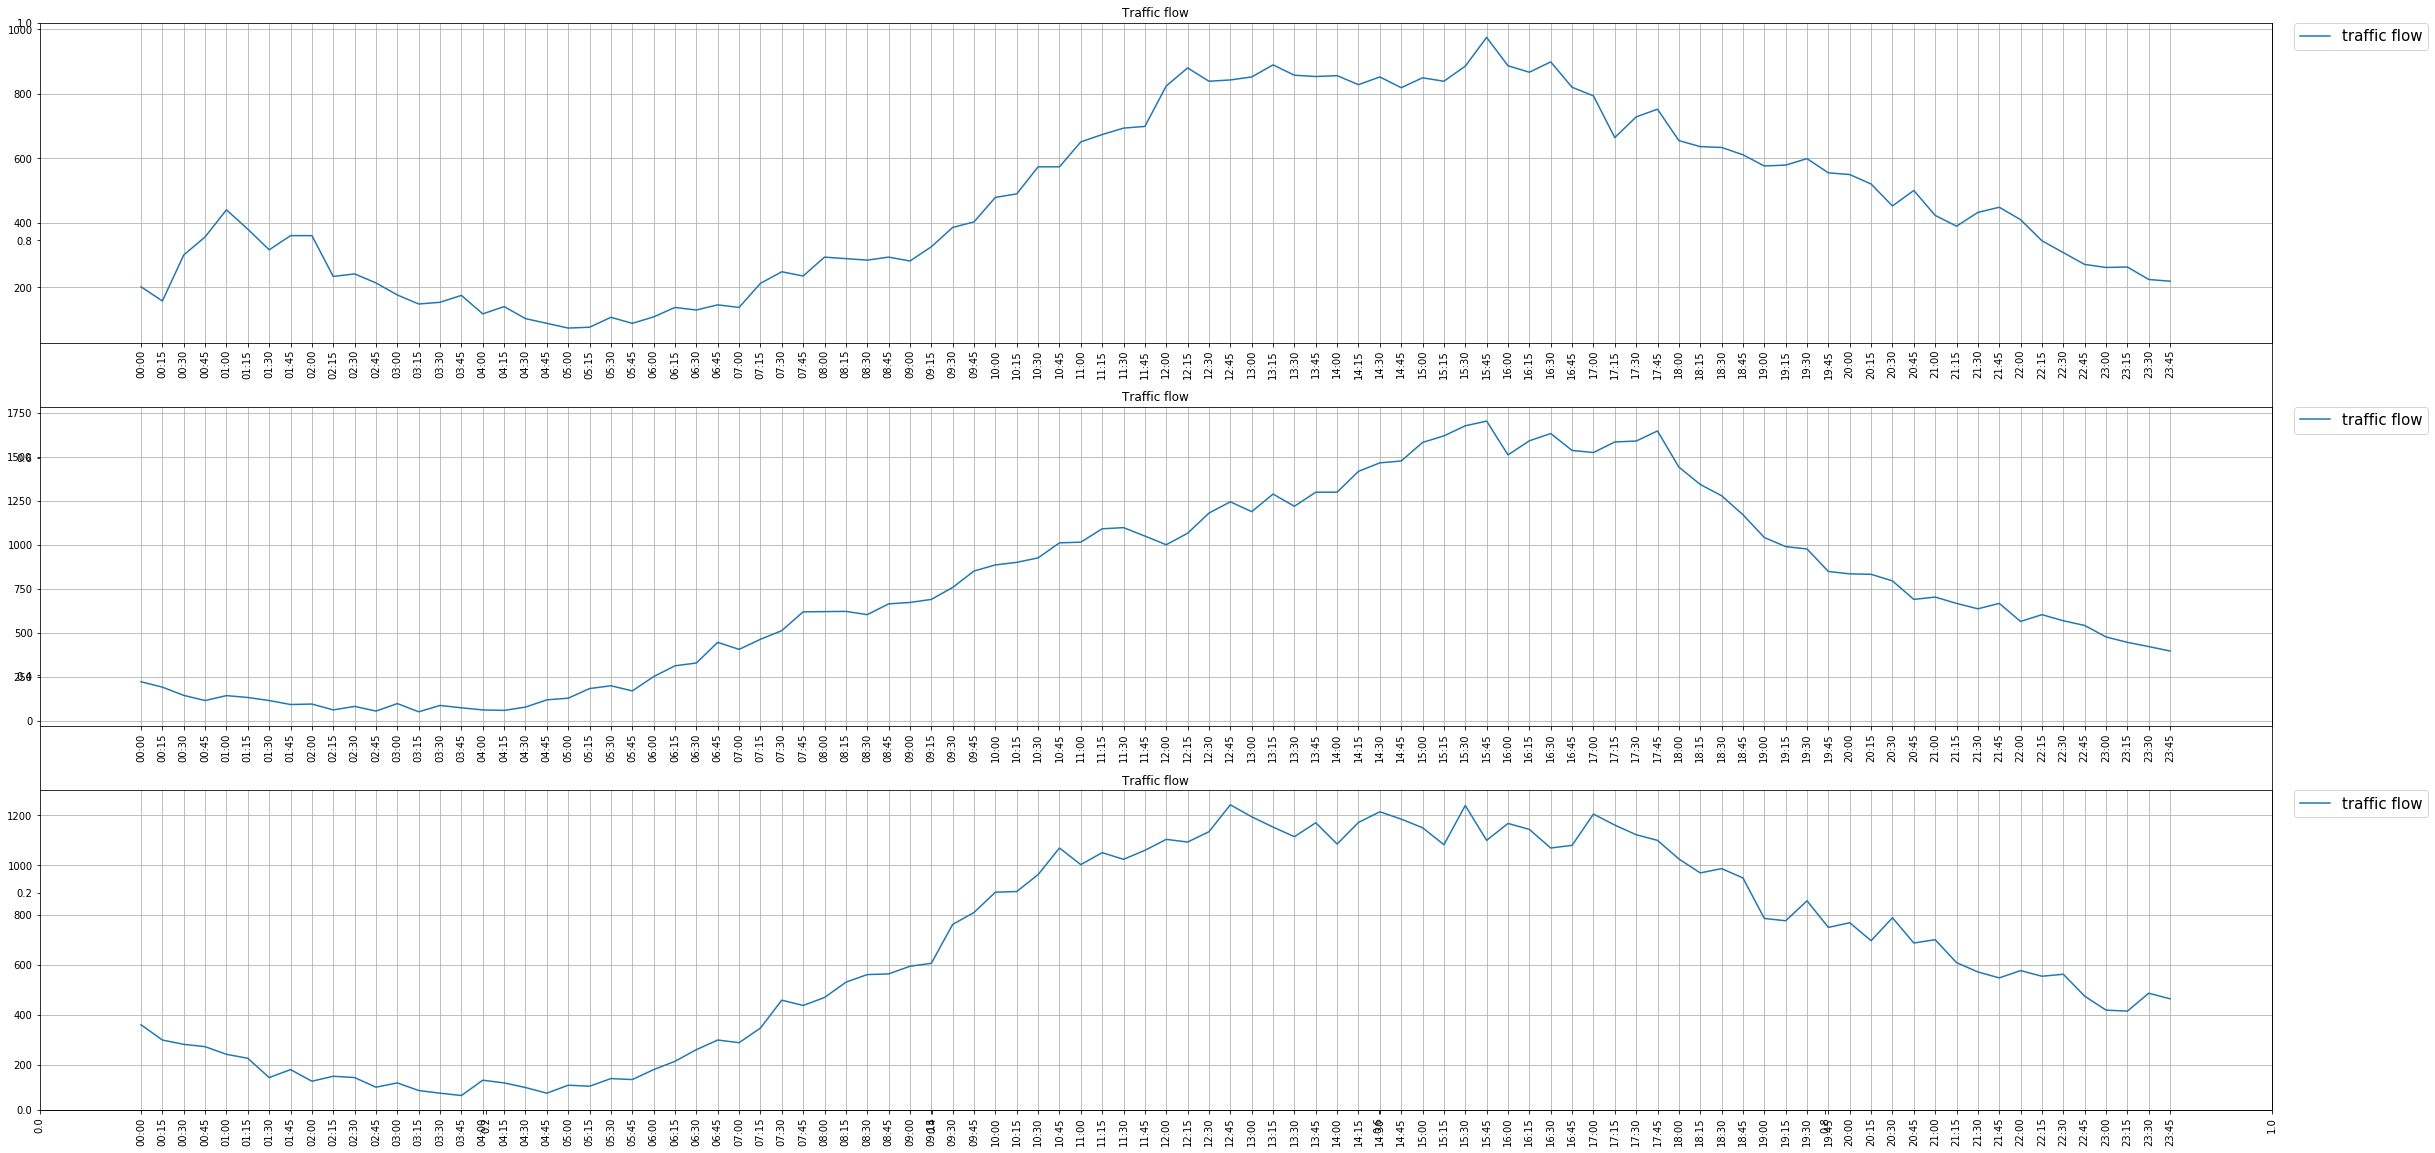

In [89]:
def plot_freeway(hours):
    dataframe = pd.read_csv('freeway_data1.csv', usecols=[1], engine='python')
    dataset = dataframe.values
    dataset = dataset.astype('float32')
    
  
    fig = plt.figure(4)
    plt.xticks(rotation=90)
    ax = fig.add_subplot(311)
    ax.plot(dts,dataset[0:96], label="traffic flow")
    ax.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax.grid(True)
    ax.set_title("Traffic flow")
    ax.tick_params(axis='x', rotation=90)

    ax2 = fig.add_subplot(312)
    ax2.plot(dts, dataset[96:192], label="traffic flow")
    ax2.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax2.grid(True)
    ax2.set_title("Traffic flow")
    ax2.tick_params(axis='x', rotation=90)

    ax3 = fig.add_subplot(313)
    ax3.plot(dts, dataset[192:288], label="traffic flow")
    ax3.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.,prop={'size': 15})#,title="ID Espira")
    ax3.grid(True)
    ax3.set_title("Traffic flow")
    ax3.tick_params(axis='x', rotation=90)
    fig.set_size_inches(40, 20)
    fig.savefig("freeway_data"+".png", dpi=100)
    
# load the dataset
dts = [dt.strftime('%H:%M') for dt in 
       datetime_range(datetime(2018, 8, 15, 0, 0), datetime(2018, 8, 15, 23, 59), 
       timedelta(minutes=15))]
print(len(dts))

plot_freeway(dts)



        

In [107]:
import math

# Estimate model performance
trainScore = model.evaluate(f_trainX, f_trainY, verbose=0)
print(model.metrics_names)
print(trainScore)
#print('Train Score: %.2f MSE (%.2f RMSE)' % (trainScore, math.sqrt(trainScore)))
#testScore = model.evaluate(testX, testY, verbose=0)
#print(testScore)

#print('Test Score: %.2f MSE (%.2f RMSE)' % (testScore, math.sqrt(testScore)))

# generate predictions for training
def predict_comparison(model, f_trainX, f_trainY,scaler):
    trainPredict = model.predict(f_trainX)
    #print(trainPredict.shape)
    inverse = scaler.inverse_transform(trainPredict)
    #print(inverse)
    f_trainY= f_trainY[:,None]
    ive = scaler.inverse_transform(f_trainY)
    #print(ive)
    print(ive[603])
    predict_comparison(model, f_trainX, f_trainY,scaler)
mape = []
for i in range(len(trainPredict)):
    err = abs(trainPredict[i]-f_trainY[i])/abs(f_trainY[i])
    if err > 1000:
        #print(err)
        #print(i)
        #print(trainPredict[i])
        #print(f_trainY[i])
        break
    #print(err)
    mape.append(err)
print(sum(mape)/(len(mape)))
#testPredict = model.predict(testX)
#print(trainPredict)
#print(trainY)
#print(testPredict)
#print(testY)
layers_conf = []
units = []
activation = []

    


['loss', 'mean_absolute_percentage_error', 'mean_absolute_error', 'mean_squared_error']
[0.021324108873175825, 4325.577417892696, 0.09707361081348558, 0.021324108873175825]
[1.9574766]


In [ ]:
for i in range(len(model.layers)):
    layer = model.layers[i].get_config()
    layers_conf.append(layer)
    units.append(layer["units"])
    activation.append(layer["activation"])
    #print(layer["units"])
    #print(layer["activation"])
if (os.stat("metrics_comparison.txt").st_size == 0):
    f = open("metrics_comparison.txt", "w+")
    f.write("N_layers,[units per layer], [activations]," + "\n")
    f.write("Metrics names: "  + str(model.metrics_names)+ "\n\n")
    
    f.write(str(len(layers_conf)) + "," + str(units) + "," +  str(activation) +"\n")
    f.write("Train Set metrics :"  + str(trainScore) +"\n")
    f.write("Test Set metrics :"  + str(testScore) +"\n\n\n")
    f.close()
else:
    f = open("metrics_comparison.txt", "a+")
    f.write(str(len(layers_conf)) + "," + str(units) + "," +  str(activation) +"\n")
    f.write("Train Set metrics :"  + str(trainScore) +"\n")
    f.write("Test Set metrics :"  + str(testScore) +"\n\n\n")
    f.close()

In [40]:

#smoothing using z_score
#not great
from scipy import stats

import numpy as np

date = copy.deepcopy(train2.iloc[:,0])
values = copy.deepcopy(train2.iloc[:,1:])
cenas = values.values

z = np.abs(stats.zscore(values))
y = np.abs(stats.zscore(cenas))
threshold = 2
z_score = np.where(y > 3)
#print(cenas[1])
#print(cenas[1,-2])
#print(train2.columns[9])
#z_score doesnt really work very well
for i in z_score[0]:
    for j in z_score[1]:
        #dois casos especiais : 0h00 e 23h45
        if j == 0:
            #values.columns[j] == "0h00":
            #dostuff
            previous_t = cenas[i,-1]
            
            next_t = cenas[i,j+1]
            cenas[i,j] = (previous_t + next_t)/2
        if j == 95:
            #dostuff
            next_t = cenas[i,0]
            previous_t = cenas[i,j-1]
            cenas[i,j] = (previous_t + next_t)/2
        else:
            previous_t = cenas[i,j-1]
            next_t = cenas[i,j+1]
            cenas[i,j] = (previous_t + next_t)/2
            #values.loc[i,values.columns[j]] = (previous_t + next_t)/2


In [95]:
print(abs(-124234))
#print(dt2.head(10))
# split into train and test sets
#train_size = int(len(dt2) * 0.8)
#test_size = len(dt2) - train_size
#train, test = dt2[0:train_size,:], dt2[train_size:len(dt2),:]


#train2 = copy.deepcopy(train)
#for column in dt2:
#    if column == "Data":
#        continue
#    else:
#        mean = dt2[column].mean()
#        stdev = dt2[column].std()
#        dt2.loc[dt2[column] > (mean + 2*stdev), column] = mean
        
    
#train_size = int(len(dataset) * 0.8)
#test_size = len(dataset) - train_size
#train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# split into train and test sets

#print(layer2.get_weights())

124234
